## Imports

In [1]:
list_of_packages <- c(
       "ggplot2",
       "dplyr",
       "tidyr",
       "ComplexHeatmap",
       "tibble",
       "RColorBrewer",
       "scales",
       "circlize",
       "argparse"
)
if (!requireNamespace("BiocManager", quietly=TRUE))
    install.packages("BiocManager")

if (!requireNamespace("ComplexHeatmap", quietly = TRUE)) {
    BiocManager::install("ComplexHeatmap")
}
for (package in list_of_packages) {
    suppressPackageStartupMessages(
        suppressWarnings(
            library(
                package,
                character.only = TRUE,
                quietly = TRUE,
                warn.conflicts = FALSE
            )
        )
    )
}

In [2]:
# set custom colors for each MOA
custom_MOA_palette <- c(
    'BRD4 inhibitor' = "#93152A",  # Dark red
    'receptor tyrosine kinase inhibitor' = "#BA3924",  # Red
    'tyrosine kinase inhibitor' = "#D08543",  # Orange
    'MEK1/2 inhibitor' = "#A1961A",  # Yellow-green/olive

    'IGF-1R inhibitor' = "#9FC62A",  # Yellow-green
    'mTOR inhibitor' = "#1FAD23",  # Green
    'PI3K inhibitor' = "#32D06A",  # Light green
    'PI3K and HDAC inhibitor' = "#15937C",  # Teal/dark green
    'HDAC inhibitor' = "#24A5BA",  # Light blue/cyan

    'Apoptosis induction' = "#438CD0",  # Medium blue
    'DNA binding' = "#1A24A1",  # Dark blue
    'HSP90 inhibitor' = "#532AC6",  # Blue-purple

    'histamine H1 receptor antagonist' = "#AD1FA6",  # Purple/magenta
    'Na+/K+ pump inhibitor' = "#D03294",  # Pink/magenta

    'Control' = "#444444"  # Gray
)

In [3]:
# Get the current working directory and find Git root
find_git_root <- function() {
    # Get current working directory
    cwd <- getwd()
    
    # Check if current directory has .git
    if (dir.exists(file.path(cwd, ".git"))) {
        return(cwd)
    }
    
    # If not, search parent directories
    current_path <- cwd
    while (dirname(current_path) != current_path) {  # While not at root
        parent_path <- dirname(current_path)
        if (dir.exists(file.path(parent_path, ".git"))) {
            return(parent_path)
        }
        current_path <- parent_path
    }
    
    # If no Git root found, stop with error
    stop("No Git root directory found.")
}

# Find the Git root directory
root_dir <- find_git_root()
cat("Git root directory:", root_dir, "\n")

Git root directory: /home/lippincm/Documents/GFF_3D_organoid_profiling_pipeline 


## Pathing for files

In [4]:
sc_consensus_df <- arrow::read_parquet(file.path(root_dir,"data/all_patient_profiles/sc_consensus_profiles.parquet"))
sc_fs_df <- arrow::read_parquet(file.path(root_dir,"data/all_patient_profiles/sc_fs_profiles.parquet"))
# drop the therapeutic category column
sc_consensus_df <- sc_consensus_df %>%
  select(-`Therapeutic Categories`)
sc_fs_df <- sc_fs_df %>%
  select(-`Therapeutic Categories`)

organoid_consensus_df <- arrow::read_parquet(file.path(root_dir,"data/all_patient_profiles/organoid_consensus_profiles.parquet"))
organoid_fs_df <- arrow::read_parquet(file.path(root_dir,"data/all_patient_profiles/organoid_fs_profiles.parquet"))
# drop the therapeutic category column
organoid_consensus_df <- organoid_consensus_df %>%
  select(-`Therapeutic Categories`)
organoid_fs_df <- organoid_fs_df %>%
  select(-`Therapeutic Categories`)


sc_consensus_heatmap_file_path <- file.path(
    root_dir,
    paste0("5.EDA/figures/heatmaps/sc_consensus_heatmap.png")
)
sc_fs_heatmap_file_path <- file.path(
    root_dir,
    paste0("5.EDA/figures/heatmaps/sc_fs_heatmap.png")
)
organoid_consensus_heatmap_file_path <- file.path(
    root_dir,
    paste0("5.EDA/figures/heatmaps/organoid_consensus_heatmap.png")
)
organoid_fs_heatmap_file_path <- file.path(
    root_dir,
    paste0("5.EDA/figures/heatmaps/organoid_fs_heatmap.png")
)


if (!dir.exists(file.path(root_dir,paste0("5.EDA/figures/heatmaps/")))) {
    dir.create(file.path(root_dir,paste0("5.EDA/figures/heatmaps/")), recursive = TRUE)
}

In [5]:
patient_colors <- rainbow(length(unique(organoid_fs_df$patient)))
names(patient_colors) <- unique(organoid_fs_df$patient)
    

## Single-cell heatmap of consensus profiles

In [15]:
head(sc_consensus_df)

patient,treatment,dose,unit,Target,Class,Area.Size.Shape_Nuclei_VOLUME,Area.Size.Shape_Nuclei_EXTENT,Area.Size.Shape_Nuclei_EULER.NUMBER,Area.Size.Shape_Nuclei_EQUIVALENT.DIAMETER,⋯,Texture_Cytoplasm_Mito_Difference.Entropy_256.3,Texture_Cytoplasm_Mito_Difference.Variance_256.3,Texture_Cytoplasm_Mito_Entropy_256.3,Texture_Cytoplasm_Mito_Information.Measure.of.Correlation.1_256.3,Texture_Cytoplasm_Mito_Information.Measure.of.Correlation.2_256.3,Texture_Cytoplasm_Mito_Inverse.Difference.Moment_256.3,Texture_Cytoplasm_Mito_Sum.Average_256.3,Texture_Cytoplasm_Mito_Sum.Entropy_256.3,Texture_Cytoplasm_Mito_Sum.Variance_256.3,Texture_Cytoplasm_Mito_Variance_256.3
<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NF0014,Binimetinib,1,uM,MEK1/2 inhibitor,Small Molecule,-0.5313876,0.2009871,-0.4219668,-0.35875093,⋯,-0.19382510,0.16157852,-0.17587940,1.09288219,-0.60244330,0.15254103,-0.30056008,-0.18710343,-0.5775799,-0.58553873
NF0014,Binimetinib,10,uM,MEK1/2 inhibitor,Small Molecule,-0.3625030,0.3267089,-0.4219668,-0.16301301,⋯,-0.05104234,0.09132523,-0.05436916,0.58793897,-0.03038526,0.09169524,-0.09947429,-0.06746389,-0.0911417,-0.02794445
NF0014,Cabozantinib,1,uM,receptor tyrosine kinase inhibitor,Small Molecule,-0.4352700,0.3959592,-0.4219668,-0.24515745,⋯,-0.08186116,0.07718774,-0.08234846,0.16036871,-0.05122659,0.07432893,-0.10150561,-0.08013297,-0.1909708,-0.19771655
NF0014,Copanlisib,1,uM,PI3K inhibitor,Small Molecule,-0.8701443,0.4219724,-0.4219668,-0.81920961,⋯,-0.14621166,0.12582486,-0.12976626,0.11524449,-0.23305153,0.11922319,-0.23204146,-0.14307351,-0.4355310,-0.44108034
NF0014,DMSO,1,%,Control,Control,-0.1548381,0.3952670,-0.4219668,0.05584441,⋯,-0.14258492,0.11899544,-0.13032451,-0.08827832,-0.16596409,0.11384213,-0.16721769,-0.13421318,-0.2421911,-0.23210500
NF0014,Digoxin,1,uM,Na+/K+ pump inhibitor,Small Molecule,-1.0897210,0.4912167,-0.4219668,-1.19274296,⋯,-0.15098166,0.13319129,-0.13011232,0.64556341,-0.30923037,0.12656625,-0.33137646,-0.13953213,-0.7403713,-0.75309441


In [16]:
# drop columns that contain neighbors
sc_consensus_df <- sc_consensus_df %>%
  select(-contains("Neighbors"))

In [17]:
column_anno <- HeatmapAnnotation(
    Target = sc_consensus_df$Target,
    show_legend = TRUE,
    annotation_name_gp = gpar(fontsize = 16),
    annotation_legend_param = list(
        title_position = "topcenter", 
        title_gp = gpar(fontsize = 16, angle = 0, fontface = "bold", hjust = 1.0),
        labels_gp = gpar(fontsize = 16, 
        title = gpar(fontsize = 16))),
    col = list(
            Target = custom_MOA_palette
        )
)
patient_columns_anno <- HeatmapAnnotation(
    patient = sc_consensus_df$patient,
    show_legend = TRUE,
    annotation_name_gp = gpar(fontsize = 16),
    annotation_legend_param = list(
        title_position = "topcenter", 
        title_gp = gpar(fontsize = 16, angle = 0, fontface = "bold", hjust = 1.0),
        labels_gp = gpar(fontsize = 16, 
        title = gpar(fontsize = 16)))

)

column_annotations = c(column_anno, patient_columns_anno)

In [18]:
# get the list of features
features <- colnames(sc_consensus_df)
features <- features[!features %in% c("treatment", "Target", "Class", "single_cell_count","patient","dose","unit")]
features <- as.data.frame(features)

rownames(features) <- features$features
# split the features by _ into multiple columns
features <- features %>% 
    separate(features, into = c("Feature Type", "Compartment", "Channel", "Measurement"), sep = "_", extra = "merge", fill = "right")
# if Feature type is AreaSizeShape then shift the Channel to the Measurement column and set Channel to NA
features <- features %>%
    mutate(
        Measurement = ifelse(`Feature Type` == "Area.Size.Shape", Channel, Measurement)
    )
features <- features %>%
    mutate(
        Channel = ifelse(`Feature Type` == "Area.Size.Shape", "None", Channel)
    )

# select the first channel for colocalization features channels are split by .
features <- features %>%
    mutate(
        Channel = ifelse(`Feature Type` == "Colocalization", 
                         sub("\\..*", "", Channel), 
                         Channel)
    )


# sort by feature type
features <- features %>%
    arrange(`Feature Type`, Compartment, Channel, Measurement)

In [19]:
# compartment row annotation
row_compartment = rowAnnotation(
    Object = features$Compartment,
        show_legend = TRUE,
    # change the legend titles
    annotation_legend_param = list(
        title_position = "topcenter", 
        title_gp = gpar(fontsize = 16, angle = 0, fontface = "bold", hjust = 1.0),
        labels_gp = gpar(fontsize = 16, 
        title = gpar(fontsize = 16))),
    annotation_name_side = "bottom",
    annotation_name_gp = gpar(fontsize = 16),
    # color
    col = list(
        Object = c(
            "Cell" = "#B000B0", 
            "Cytoplasm" = "#00D55B", 
            "Nuclei" = "#0000AB"
            )
    )
)
row_measurement = rowAnnotation(
    FeatureType = features$`Feature Type`,
           annotation_legend_param = list(
        title_position = "topcenter", 
        title_gp = gpar(fontsize = 16, angle = 0, fontface = "bold", hjust = 0.5),
        labels_gp = gpar(fontsize = 16, 
        title = gpar(fontsize = 16))),
    annotation_name_side = "bottom",
    annotation_name_gp = gpar(fontsize = 16),
    col = list(
            FeatureType = c(
            "Area.Size.Shape" = brewer.pal(8, "Paired")[1],
            "Colocalization" = brewer.pal(8, "Paired")[2],
            "Granularity" = brewer.pal(8, "Paired")[3],
            "Intensity" = brewer.pal(8, "Paired")[4],
            "Texture" = brewer.pal(8, "Paired")[8]
        )
    ),
    show_legend = TRUE
)
row_channel = rowAnnotation(
    Channel = features$Channel,
        annotation_legend_param = list(
        title_position = "topcenter", 
        title_gp = gpar(fontsize = 16, angle = 0, fontface = "bold", hjust = 0.5),
        labels_gp = gpar(fontsize = 16, 
        # make annotation bar text bigger
        legend = gpar(fontsize = 16),
        annotation_name = gpar(fontsize = 16),
        # legend_height = unit(20, "cm"),
        legend_width = unit(1, "cm"),
        # make legend taller
        # legend_height = unit(10, "cm"),
        legend_width = unit(1, "cm"),
        legend_key = gpar(fontsize = 16)
        )
    ),


        
    annotation_name_side = "bottom",
    # make font size bigger
    annotation_name_gp = gpar(fontsize = 16),
    col = list(
    Channel = c(
            "DNA" = "#0000AB",
            "AGP" = "#b1001a",
            "Mito" = "#B000B0",
            "ER" = "#00D55B",
            "BF" = "#FFFF00",
            "None" = "#B09FB0")
    )
)
row_annotations = c(row_compartment, row_measurement, row_channel)

In [20]:
mat <- sc_consensus_df %>%
  select(-treatment, -Class, -Target,-patient,-dose,-unit) %>%
  
  as.matrix()
mat <- t(mat)
colnames(mat) <- sc_consensus_df$treatment
dim(mat)

[1] 1259  171

The automatically generated colors map from the minus and plus 99^th of
the absolute values in the matrix. There are outliers in the matrix
whose patterns might be hidden by this color mapping. You can manually
set the color to `col` argument.

Use `suppressMessages()` to turn off this message.



png 
  2

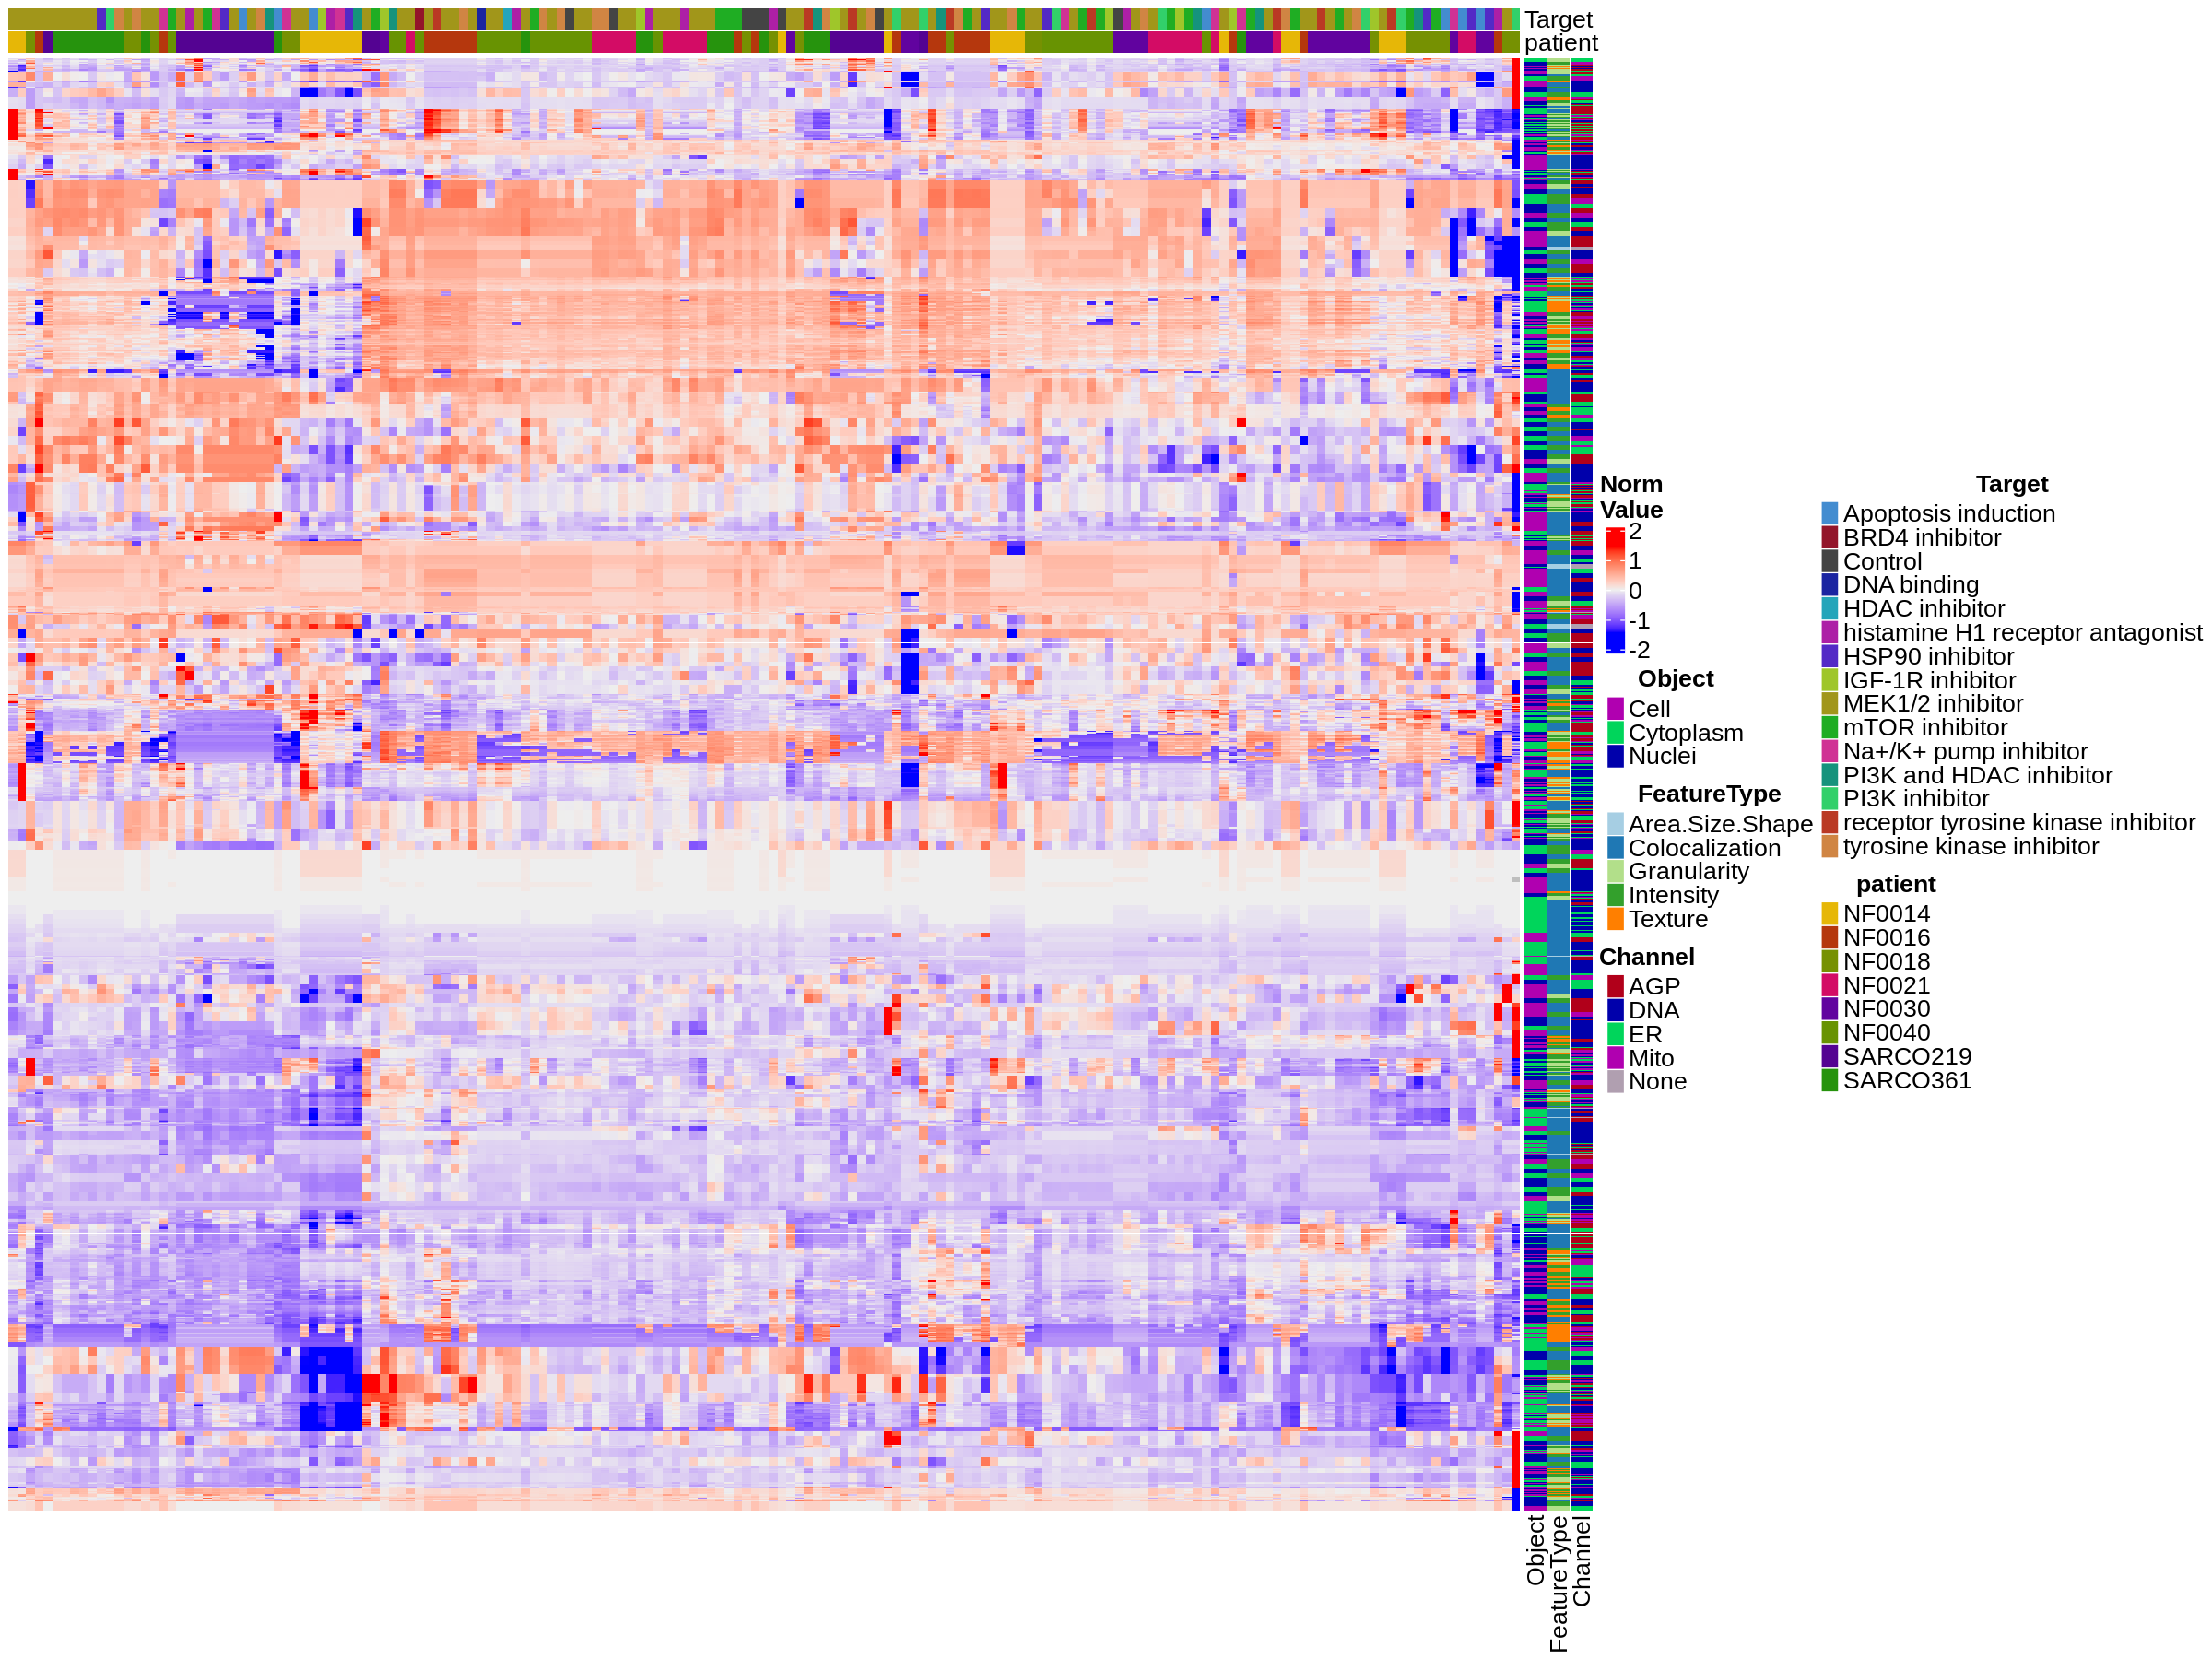

In [21]:
width <- 20
height <- 15
options(repr.plot.width = width, repr.plot.height = height)
heatmap_plot <- Heatmap(
        mat, 
        # col = col_fun,
        show_row_names = FALSE,
        # cluster_columns = FALSE,
        show_column_names = FALSE,
        row_dend_reorder = TRUE, # reorder rows based on dendrogram
        column_dend_reorder = TRUE, # reorder columns based on dendrogram
        show_row_dend = FALSE,
        show_column_dend = FALSE,

        column_names_gp = gpar(fontsize = 16), # Column name label formatting
        row_names_gp = gpar(fontsize = 14), 

        # show_heatmap_legend = FALSE,
        heatmap_legend_param = list(
                    title = "Norm\nValue",
                    title_position = "topcenter", 
                    title_gp = gpar(fontsize = 16, angle = 0, fontface = "bold", hjust = 1.0),
                    labels_gp = gpar(fontsize = 16),
                    # legend_height = unit(2, "cm"),
                    legend_width = unit(3, "cm"),
                    annotation_legend_side = "bottom"
                    ), 
        
        row_dend_width = unit(1, "cm"),
        column_dend_height = unit(1, "cm"),
        
        # column_title = paste0("Dose: ", dose," uM"),
        right_annotation = row_annotations,
        top_annotation = column_annotations,
        # adjust the title position and size
        column_title_gp = gpar(fontsize = 16, fontface = "bold", hjust = 0.5),
    
    )

png(sc_consensus_heatmap_file_path, width = width, height = height, units = "in", res = 600)
# save as a PNG
draw(heatmap_plot, merge_legend = TRUE, heatmap_legend_side = "right")
dev.off()
heatmap_plot

## Single-cell heatmap of sc fs profiles

In [ ]:
head(sc_fs_df)


In [ ]:
# drop columns that contain neighbors
sc_fs_df <- sc_fs_df %>%
  select(-contains("Neighbors"))

In [ ]:
column_anno <- HeatmapAnnotation(
    Target = sc_fs_df$Target,
    show_legend = TRUE,
    annotation_name_gp = gpar(fontsize = 16),
    annotation_legend_param = list(
        title_position = "topcenter", 
        title_gp = gpar(fontsize = 16, angle = 0, fontface = "bold", hjust = 1.0),
        labels_gp = gpar(fontsize = 16, 
        title = gpar(fontsize = 16))),
    col = list(
            Target = custom_MOA_palette
        )
)

patient_colors <- rainbow(length(unique(sc_fs_df$patient)))
names(patient_colors) <- unique(sc_fs_df$patient)

patient_columns_anno <- HeatmapAnnotation(
    Patient = sc_fs_df$patient,
    col = list(Patient = patient_colors),
    show_legend = TRUE,
    annotation_name_gp = gpar(fontsize = 16),
    annotation_legend_param = list(
        title_position = "topcenter", 
        title_gp = gpar(fontsize = 16, angle = 0, fontface = "bold", hjust = 1.0),
        labels_gp = gpar(fontsize = 16, 
        title = gpar(fontsize = 16)))
)

depth_anno <- HeatmapAnnotation(
    Depth = sc_fs_df$Area.Size.Shape_Cell_CENTER.Z,
    show_legend = TRUE,
    annotation_name_gp = gpar(fontsize = 16),
    annotation_legend_param = list(
        title_position = "topcenter",
        title_gp = gpar(fontsize = 16, angle = 0, fontface = "bold", hjust = 1.0),
        labels_gp = gpar(fontsize = 16, 
        title = gpar(fontsize = 16)))
)

column_annotations = c(column_anno, patient_columns_anno, depth_anno)


In [ ]:
# get the list of features
features <- colnames(sc_fs_df)
features <- features[!features %in% c("treatment", "Target", "Class", "single_cell_count", "patient",
         "object_id",
         "unit",
         "dose",
         "image_set",
         "Well",
         "parent_organoid",
         "Area.Size.Shape_Cell_CENTER.X",
         "Area.Size.Shape_Cell_CENTER.Y",
         "Area.Size.Shape_Cell_CENTER.Z")]
features <- as.data.frame(features)
rownames(features) <- features$features
# split the features by _ into multiple columns
features <- features %>% 
    separate(features, into = c("Feature Type", "Compartment", "Channel", "Measurement"), sep = "_", extra = "merge", fill = "right")
# if Feature type is AreaSizeShape then shift the Channel to the Measurement column and set Channel to NA
features <- features %>%
    mutate(
        Measurement = ifelse(`Feature Type` == "Area.Size.Shape", Channel, Measurement)
    )
features <- features %>%
    mutate(
        Channel = ifelse(`Feature Type` == "Area.Size.Shape", "None", Channel)
    )

# select the first channel for colocalization features channels are split by .
features <- features %>%
    mutate(
        Channel = ifelse(`Feature Type` == "Colocalization", 
                         sub("\\..*", "", Channel), 
                         Channel)
    )


# sort by feature type
features <- features %>%
    arrange(`Feature Type`, Compartment, Channel, Measurement)

In [ ]:
# compartment row annotation
row_compartment = rowAnnotation(
    Object = features$Compartment,
        show_legend = TRUE,
    # change the legend titles
    annotation_legend_param = list(
        title_position = "topcenter", 
        title_gp = gpar(fontsize = 16, angle = 0, fontface = "bold", hjust = 1.0),
        labels_gp = gpar(fontsize = 16, 
        title = gpar(fontsize = 16))),
    annotation_name_side = "bottom",
    annotation_name_gp = gpar(fontsize = 16),
    # color
    col = list(
        Object = c(
            "Cell" = "#B000B0", 
            "Cytoplasm" = "#00D55B", 
            "Nuclei" = "#0000AB"
            )
    )
)
row_measurement = rowAnnotation(
    FeatureType = features$`Feature Type`,
           annotation_legend_param = list(
        title_position = "topcenter", 
        title_gp = gpar(fontsize = 16, angle = 0, fontface = "bold", hjust = 0.5),
        labels_gp = gpar(fontsize = 16, 
        title = gpar(fontsize = 16))),
    annotation_name_side = "bottom",
    annotation_name_gp = gpar(fontsize = 16),
    col = list(
            FeatureType = c(
            "Area.Size.Shape" = brewer.pal(8, "Paired")[1],
            "Colocalization" = brewer.pal(8, "Paired")[2],
            "Granularity" = brewer.pal(8, "Paired")[3],
            "Intensity" = brewer.pal(8, "Paired")[4],
            "Texture" = brewer.pal(8, "Paired")[8]
        )
    ),
    show_legend = TRUE
)
row_channel = rowAnnotation(
    Channel = features$Channel,
        annotation_legend_param = list(
        title_position = "topcenter", 
        title_gp = gpar(fontsize = 16, angle = 0, fontface = "bold", hjust = 0.5),
        labels_gp = gpar(fontsize = 16, 
        # make annotation bar text bigger
        legend = gpar(fontsize = 16),
        annotation_name = gpar(fontsize = 16),
        # legend_height = unit(20, "cm"),
        legend_width = unit(1, "cm"),
        # make legend taller
        # legend_height = unit(10, "cm"),
        legend_width = unit(1, "cm"),
        legend_key = gpar(fontsize = 16)
        )
    ),


        
    annotation_name_side = "bottom",
    # make font size bigger
    annotation_name_gp = gpar(fontsize = 16),
    col = list(
    Channel = c(
            "DNA" = "#0000AB",
            "AGP" = "#b1001a",
            "Mito" = "#B000B0",
            "ER" = "#00D55B",
            "BF" = "#FFFF00",
            "None" = "#B09FB0")
    )
)
row_annotations = c(row_compartment, row_measurement, row_channel)

In [ ]:
mat <- sc_fs_df %>%
  select(-treatment, -Class, -Target, -patient,
        -object_id,
         -unit,
         -dose,
         -image_set,
         -Well,
         -parent_organoid,
         -Area.Size.Shape_Cell_CENTER.X,
         -Area.Size.Shape_Cell_CENTER.Y,
         -Area.Size.Shape_Cell_CENTER.Z
         ) %>%
  
  as.matrix()
mat <- t(mat)
colnames(mat) <- sc_fs_df$treatment
dim(mat)

In [ ]:
width <- 20
height <- 15
options(repr.plot.width = width, repr.plot.height = height)
heatmap_plot <- Heatmap(
        mat, 
        # col = col_fun,
        show_row_names = FALSE,
        # cluster_columns = FALSE,
        show_column_names = FALSE,
        row_dend_reorder = TRUE, # reorder rows based on dendrogram
        column_dend_reorder = TRUE, # reorder columns based on dendrogram
        show_row_dend = FALSE,
        show_column_dend = FALSE,

        column_names_gp = gpar(fontsize = 16), # Column name label formatting
        row_names_gp = gpar(fontsize = 14), 

        # show_heatmap_legend = FALSE,
        heatmap_legend_param = list(
                    title = "Norm\nValue",
                    title_position = "topcenter", 
                    title_gp = gpar(fontsize = 16, angle = 0, fontface = "bold", hjust = 1.0),
                    labels_gp = gpar(fontsize = 16),
                    # legend_height = unit(2, "cm"),
                    legend_width = unit(3, "cm"),
                    annotation_legend_side = "bottom"
                    ), 
        
        row_dend_width = unit(4, "cm"),
        column_dend_height = unit(4, "cm"),
        # column_title = paste0("Dose: ", dose," uM"),
        right_annotation = row_annotations,
        top_annotation = column_annotations,
        # adjust the title position and size
        column_title_gp = gpar(fontsize = 16, fontface = "bold", hjust = 0.5),
    
    )
png(sc_fs_heatmap_file_path, width = width, height = height, units = "in", res = 600)
# save as a PNG
draw(heatmap_plot, merge_legend = TRUE, heatmap_legend_side = "right")
dev.off()
heatmap_plot

## Organoid heatmap of consensus profiles

In [ ]:
head(organoid_consensus_df)

In [ ]:
# drop columns that contain neighbors
organoid_consensus_df <- organoid_consensus_df %>%
  select(-contains("Neighbors"))

In [ ]:
column_anno <- HeatmapAnnotation(
    Target = organoid_consensus_df$Target,
    show_legend = TRUE,
    annotation_name_gp = gpar(fontsize = 16),
    annotation_legend_param = list(
        title_position = "topcenter", 
        title_gp = gpar(fontsize = 16, angle = 0, fontface = "bold", hjust = 1.0),
        labels_gp = gpar(fontsize = 16, 
        title = gpar(fontsize = 16))),
    col = list(
            Target = custom_MOA_palette
        )
)
patient_columns_anno <- HeatmapAnnotation(
    patient = organoid_consensus_df$patient,
    show_legend = TRUE,
    annotation_name_gp = gpar(fontsize = 16),
    annotation_legend_param = list(
        title_position = "topcenter", 
        title_gp = gpar(fontsize = 16, angle = 0, fontface = "bold", hjust = 1.0),
        labels_gp = gpar(fontsize = 16, 
        title = gpar(fontsize = 16)))

)

column_annotations = c(column_anno, patient_columns_anno)

In [ ]:
head(organoid_consensus_df)

In [ ]:
# get the list of features
features <- colnames(organoid_consensus_df)
features <- features[!features %in% c("treatment", "Target", "Class", "single_cell_count","patient","dose","unit")]
features <- as.data.frame(features)

rownames(features) <- features$features
# split the features by _ into multiple columns
features <- features %>% 
    separate(features, into = c("Feature Type", "Compartment", "Channel", "Measurement"), sep = "_", extra = "merge", fill = "right")
# if Feature type is AreaSizeShape then shift the Channel to the Measurement column and set Channel to NA
features <- features %>%
    mutate(
        Measurement = ifelse(`Feature Type` == "Area.Size.Shape", Channel, Measurement)
    )
features <- features %>%
    mutate(
        Channel = ifelse(`Feature Type` == "Area.Size.Shape", "None", Channel)
    )

# select the first channel for colocalization features channels are split by .
features <- features %>%
    mutate(
        Channel = ifelse(`Feature Type` == "Colocalization", 
                         sub("\\..*", "", Channel), 
                         Channel)
    )


# sort by feature type
features <- features %>%
    arrange(`Feature Type`, Compartment, Channel, Measurement)

In [ ]:
row_measurement = rowAnnotation(
    FeatureType = features$`Feature Type`,
           annotation_legend_param = list(
        title_position = "topcenter", 
        title_gp = gpar(fontsize = 16, angle = 0, fontface = "bold", hjust = 0.5),
        labels_gp = gpar(fontsize = 16, 
        title = gpar(fontsize = 16))),
    annotation_name_side = "bottom",
    annotation_name_gp = gpar(fontsize = 16),
    col = list(
            FeatureType = c(
            "Area.Size.Shape" = brewer.pal(8, "Paired")[1],
            "Colocalization" = brewer.pal(8, "Paired")[2],
            "Granularity" = brewer.pal(8, "Paired")[3],
            "Intensity" = brewer.pal(8, "Paired")[4],
            "Texture" = brewer.pal(8, "Paired")[8]
        )
    ),
    show_legend = TRUE
)
row_channel = rowAnnotation(
    Channel = features$Channel,
        annotation_legend_param = list(
        title_position = "topcenter", 
        title_gp = gpar(fontsize = 16, angle = 0, fontface = "bold", hjust = 0.5),
        labels_gp = gpar(fontsize = 16, 
        # make annotation bar text bigger
        legend = gpar(fontsize = 16),
        annotation_name = gpar(fontsize = 16),
        # legend_height = unit(20, "cm"),
        legend_width = unit(1, "cm"),
        # make legend taller
        # legend_height = unit(10, "cm"),
        legend_width = unit(1, "cm"),
        legend_key = gpar(fontsize = 16)
        )
    ),


        
    annotation_name_side = "bottom",
    # make font size bigger
    annotation_name_gp = gpar(fontsize = 16),
    col = list(
    Channel = c(
            "DNA" = "#0000AB",
            "AGP" = "#b1001a",
            "Mito" = "#B000B0",
            "ER" = "#00D55B",
            "BF" = "#FFFF00",
            "None" = "#B09FB0")
    )
)
row_annotations = c(row_measurement, row_channel)

In [ ]:
mat <- organoid_consensus_df %>%
  select(-treatment, -Class, -Target,-patient,-dose,-unit) %>%

  as.matrix()
mat <- t(mat)
colnames(mat) <- organoid_consensus_df$treatment
dim(mat)

In [ ]:
width <- 20
height <- 15
options(repr.plot.width = width, repr.plot.height = height)
heatmap_plot <- Heatmap(
        mat, 
        # col = col_fun,
        show_row_names = FALSE,
        # cluster_columns = FALSE,
        show_column_names = FALSE,
        row_dend_reorder = TRUE, # reorder rows based on dendrogram
        column_dend_reorder = TRUE, # reorder columns based on dendrogram
        show_row_dend = FALSE,
        show_column_dend = FALSE,

        column_names_gp = gpar(fontsize = 16), # Column name label formatting
        row_names_gp = gpar(fontsize = 14), 

        # show_heatmap_legend = FALSE,
        heatmap_legend_param = list(
                    title = "Norm\nValue",
                    title_position = "topcenter", 
                    title_gp = gpar(fontsize = 16, angle = 0, fontface = "bold", hjust = 1.0),
                    labels_gp = gpar(fontsize = 16),
                    # legend_height = unit(2, "cm"),
                    legend_width = unit(3, "cm"),
                    annotation_legend_side = "bottom"
                    ), 
        
        row_dend_width = unit(1, "cm"),
        column_dend_height = unit(1, "cm"),
        
        # column_title = paste0("Dose: ", dose," uM"),
        right_annotation = row_annotations,
        top_annotation = column_annotations,
        # adjust the title position and size
        column_title_gp = gpar(fontsize = 16, fontface = "bold", hjust = 0.5),
    
    )

png(organoid_consensus_heatmap_file_path, width = width, height = height, units = "in", res = 600)
# save as a PNG
draw(heatmap_plot, merge_legend = TRUE, heatmap_legend_side = "right")
dev.off()
heatmap_plot

## Organoid heatmap of sc fs profiles

In [6]:
head(organoid_fs_df)


patient,object_id,unit,dose,treatment,Target,Class,image_set,Well,single_cell_count,⋯,Texture_Organoid_Mito_Difference.Entropy_256.3,Texture_Organoid_Mito_Difference.Variance_256.3,Texture_Organoid_Mito_Entropy_256.3,Texture_Organoid_Mito_Information.Measure.of.Correlation.1_256.3,Texture_Organoid_Mito_Information.Measure.of.Correlation.2_256.3,Texture_Organoid_Mito_Inverse.Difference.Moment_256.3,Texture_Organoid_Mito_Sum.Average_256.3,Texture_Organoid_Mito_Sum.Entropy_256.3,Texture_Organoid_Mito_Sum.Variance_256.3,Texture_Organoid_Mito_Variance_256.3
<chr>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NF0014,40,uM,10,Mirdametinib,MEK1/2 inhibitor,Small Molecule,G8-1,G8,8,⋯,-1.9289166,1.9985968,-1.86580689,-0.7239699,-1.4837900,2.0029701,-1.3806942,-1.952114993,-0.97423540,-0.9866679
NF0014,24,uM,1,Fimepinostat,PI3K and HDAC inhibitor,Small Molecule,D5-1,D5,5,⋯,0.9681539,-0.8213764,-0.07963857,2.9647481,-5.4890248,-0.9640059,-1.4852353,-0.005152971,-1.11498234,-1.0633384
NF0014,85,uM,1,Mirdametinib,MEK1/2 inhibitor,Small Molecule,F8-1,F8,9,⋯,1.7182974,-2.2434691,2.41331838,0.5918269,1.1936021,-1.6318938,-0.9224064,2.227469169,-1.18049700,-1.1909291
NF0014,18,nM,10,Staurosporine,Apoptosis induction,Small Molecule,G11-1,G11,1,⋯,-2.2429273,2.1738372,-2.17966264,-1.1546939,-1.8380681,2.0853893,-1.1937030,-2.246652125,-0.72076301,-0.7253987
NF0014,24,uM,1,Binimetinib,MEK1/2 inhibitor,Small Molecule,G7-1,G7,7,⋯,-0.9504052,1.2371150,-0.91691891,-0.5822487,-0.1492245,1.2119343,-0.3678275,-0.966047855,0.08177495,0.0728355
NF0014,30,uM,1,Copanlisib,PI3K inhibitor,Small Molecule,E3-2,E3,9,⋯,-1.7385579,1.9470442,-1.53030843,-0.6031748,-0.9699387,1.9560622,-0.9324702,-1.789451208,-0.23151379,-0.2433724


In [7]:
# drop columns that contain neighbors
organoid_fs_df <- organoid_fs_df %>%
  select(-contains("Neighbors")) %>%
  select(-contains("single_cell_count"))

In [8]:
dim(organoid_fs_df)
# drop all rows that have any NA values
organoid_fs_df <- organoid_fs_df %>%
  filter(complete.cases(.))
dim(organoid_fs_df)

[1] 1481  441

[1] 1428  441

In [9]:
column_anno <- HeatmapAnnotation(
    Target = organoid_fs_df$Target,
    show_legend = TRUE,
    annotation_name_gp = gpar(fontsize = 16),
    annotation_legend_param = list(
        title_position = "topcenter", 
        title_gp = gpar(fontsize = 16, angle = 0, fontface = "bold", hjust = 1.0),
        labels_gp = gpar(fontsize = 16, 
        title = gpar(fontsize = 16))),
    col = list(
            Target = custom_MOA_palette
        )
)

patient_columns_anno <- HeatmapAnnotation(
    Patient = organoid_fs_df$patient,
    show_legend = TRUE,
    annotation_name_gp = gpar(fontsize = 16),
    annotation_legend_param = list(
        title_position = "topcenter", 
        title_gp = gpar(fontsize = 16, angle = 0, fontface = "bold", hjust = 1.0),
        labels_gp = gpar(fontsize = 16, 
        title = gpar(fontsize = 16)))
)

depth_anno <- HeatmapAnnotation(
    Depth = organoid_fs_df$Area.Size.Shape_Organoid_CENTER.Z,
    show_legend = TRUE,
    annotation_name_gp = gpar(fontsize = 16),
    annotation_legend_param = list(
        title_position = "topcenter",
        title_gp = gpar(fontsize = 16, angle = 0, fontface = "bold", hjust = 1.0),
        labels_gp = gpar(fontsize = 16, 
        title = gpar(fontsize = 16)))
)

column_annotations = c(column_anno, patient_columns_anno, depth_anno)


In [10]:
# get the list of features
features <- colnames(organoid_fs_df)
features <- features[!features %in% c("treatment", "Target", "Class", "single_cell_count", "patient",
         "object_id",
         "unit",
         "dose",
         "image_set",
         "Well",
         "single_cell_count",
         "Area.Size.Shape_Organoid_CENTER.X",
         "Area.Size.Shape_Organoid_CENTER.Y",
         "Area.Size.Shape_Organoid_CENTER.Z"
         )]
features <- as.data.frame(features)
rownames(features) <- features$features
# split the features by _ into multiple columns
features <- features %>% 
    separate(features, into = c("Feature Type", "Compartment", "Channel", "Measurement"), sep = "_", extra = "merge", fill = "right")
# if Feature type is AreaSizeShape then shift the Channel to the Measurement column and set Channel to NA
features <- features %>%
    mutate(
        Measurement = ifelse(`Feature Type` == "Area.Size.Shape", Channel, Measurement)
    )
features <- features %>%
    mutate(
        Channel = ifelse(`Feature Type` == "Area.Size.Shape", "None", Channel)
    )

# select the first channel for colocalization features channels are split by .
features <- features %>%
    mutate(
        Channel = ifelse(`Feature Type` == "Colocalization", 
                         sub("\\..*", "", Channel), 
                         Channel)
    )


# sort by feature type
features <- features %>%
    arrange(`Feature Type`, Compartment, Channel, Measurement)

In [11]:
row_measurement = rowAnnotation(
    FeatureType = features$`Feature Type`,
           annotation_legend_param = list(
        title_position = "topcenter", 
        title_gp = gpar(fontsize = 16, angle = 0, fontface = "bold", hjust = 0.5),
        labels_gp = gpar(fontsize = 16, 
        title = gpar(fontsize = 16))),
    annotation_name_side = "bottom",
    annotation_name_gp = gpar(fontsize = 16),
    col = list(
            FeatureType = c(
            "Area.Size.Shape" = brewer.pal(8, "Paired")[1],
            "Colocalization" = brewer.pal(8, "Paired")[2],
            "Granularity" = brewer.pal(8, "Paired")[3],
            "Intensity" = brewer.pal(8, "Paired")[4],
            "Texture" = brewer.pal(8, "Paired")[8]
        )
    ),
    show_legend = TRUE
)
row_channel = rowAnnotation(
    Channel = features$Channel,
        annotation_legend_param = list(
        title_position = "topcenter", 
        title_gp = gpar(fontsize = 16, angle = 0, fontface = "bold", hjust = 0.5),
        labels_gp = gpar(fontsize = 16, 
        # make annotation bar text bigger
        legend = gpar(fontsize = 16),
        annotation_name = gpar(fontsize = 16),
        # legend_height = unit(20, "cm"),
        legend_width = unit(1, "cm"),
        # make legend taller
        # legend_height = unit(10, "cm"),
        legend_width = unit(1, "cm"),
        legend_key = gpar(fontsize = 16)
        )
    ),


        
    annotation_name_side = "bottom",
    # make font size bigger
    annotation_name_gp = gpar(fontsize = 16),
    col = list(
    Channel = c(
            "DNA" = "#0000AB",
            "AGP" = "#b1001a",
            "Mito" = "#B000B0",
            "ER" = "#00D55B",
            "BF" = "#FFFF00",
            "None" = "#B09FB0")
    )
)
row_annotations = c(row_measurement, row_channel)

In [13]:
mat <- organoid_fs_df %>%
  select(-treatment, -Class, -Target, -patient, -object_id, -image_set, -Well,
         -unit,
         -dose,
         -Area.Size.Shape_Organoid_CENTER.X,
         -Area.Size.Shape_Organoid_CENTER.Y,
         -Area.Size.Shape_Organoid_CENTER.Z
         ) %>%
  
  as.matrix()
mat <- t(mat)
colnames(mat) <- organoid_fs_df$treatment
dim(mat)

[1]  429 1428

The automatically generated colors map from the minus and plus 99^th of
the absolute values in the matrix. There are outliers in the matrix
whose patterns might be hidden by this color mapping. You can manually
set the color to `col` argument.

Use `suppressMessages()` to turn off this message.



png 
  2

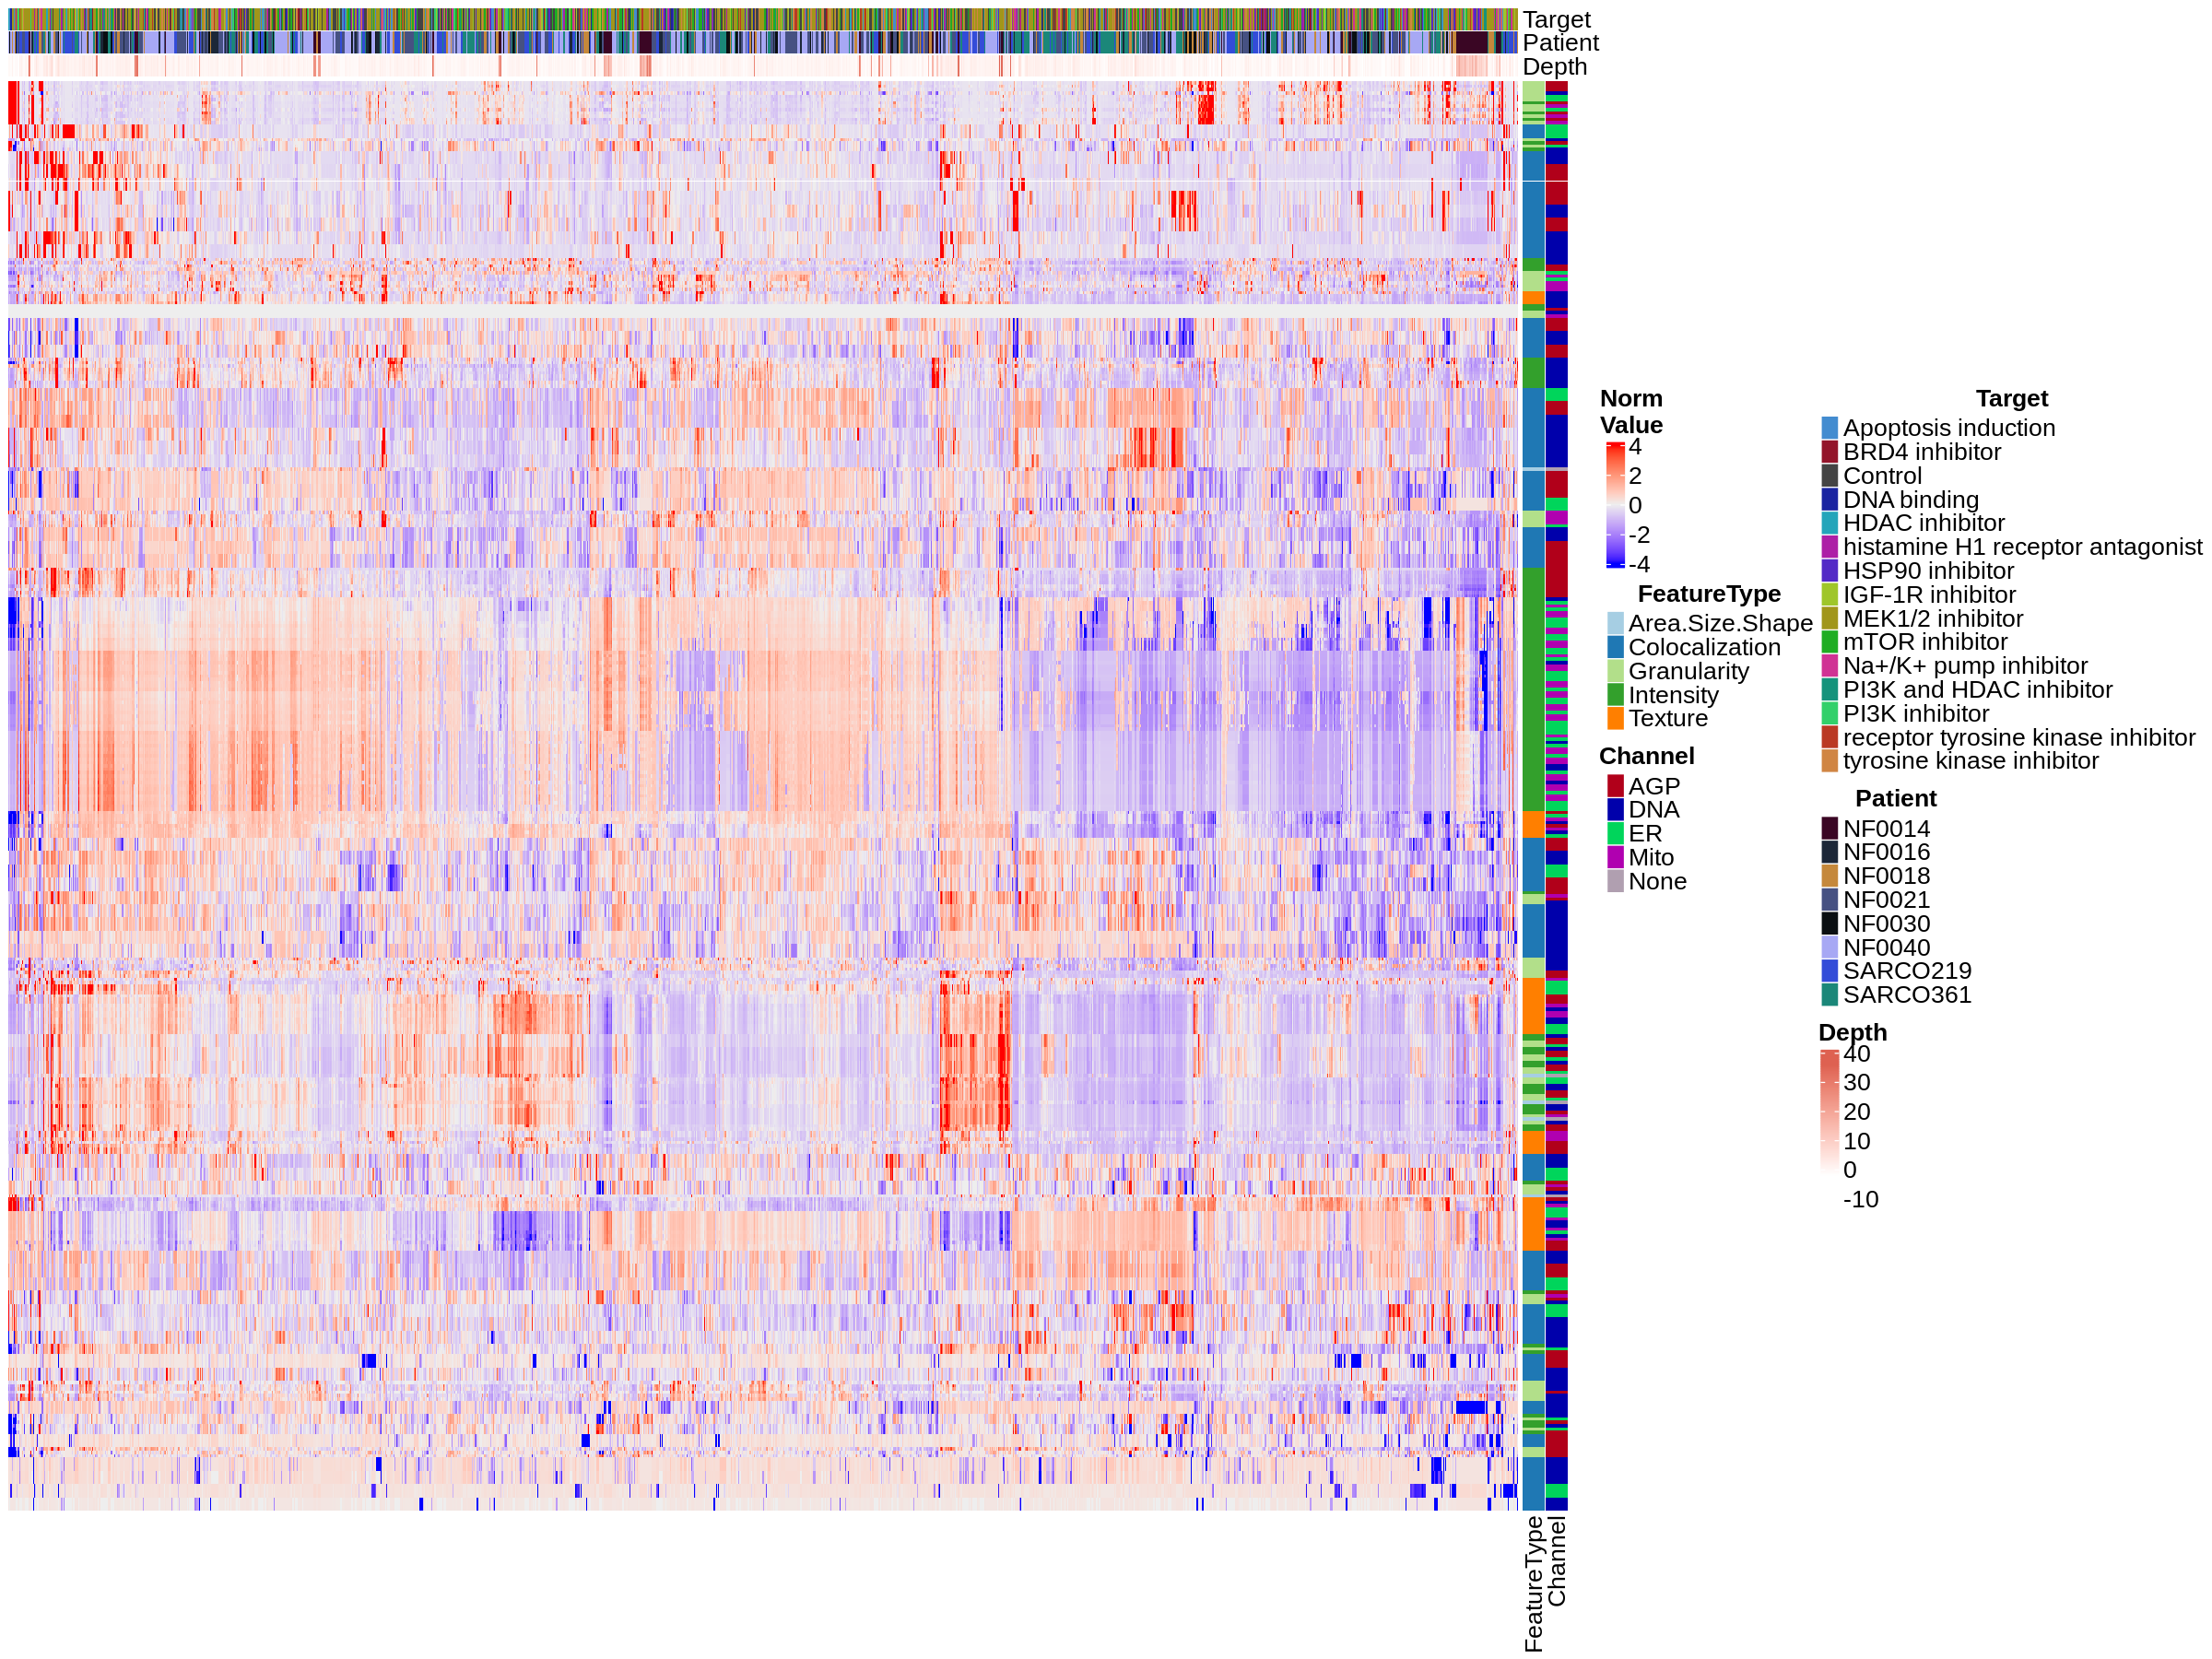

In [14]:
width <- 20
height <- 15
options(repr.plot.width = width, repr.plot.height = height)
heatmap_plot <- Heatmap(
        mat, 
        # col = col_fun,
        show_row_names = FALSE,
        # cluster_columns = FALSE,
        show_column_names = FALSE,
        row_dend_reorder = TRUE, # reorder rows based on dendrogram
        column_dend_reorder = TRUE, # reorder columns based on dendrogram
        show_row_dend = FALSE,
        show_column_dend = FALSE,

        column_names_gp = gpar(fontsize = 16), # Column name label formatting
        row_names_gp = gpar(fontsize = 14), 

        # show_heatmap_legend = FALSE,
        heatmap_legend_param = list(
                    title = "Norm\nValue",
                    title_position = "topcenter", 
                    title_gp = gpar(fontsize = 16, angle = 0, fontface = "bold", hjust = 1.0),
                    labels_gp = gpar(fontsize = 16),
                    # legend_height = unit(2, "cm"),
                    legend_width = unit(3, "cm"),
                    annotation_legend_side = "bottom"
                    ), 
        
        row_dend_width = unit(4, "cm"),
        column_dend_height = unit(4, "cm"),
        # column_title = paste0("Dose: ", dose," uM"),
        right_annotation = row_annotations,
        top_annotation = column_annotations,
        # adjust the title position and size
        column_title_gp = gpar(fontsize = 16, fontface = "bold", hjust = 0.5),
    
    )
png(organoid_fs_heatmap_file_path, width = width, height = height, units = "in", res = 600)
# save as a PNG
draw(heatmap_plot, merge_legend = TRUE, heatmap_legend_side = "right")
dev.off()
heatmap_plot